In [1]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram, plot_bloch_vector, plot_bloch_multivector
from qiskit.primitives import BackendSampler
from qiskit.quantum_info import SparsePauliOp, Statevector, Pauli
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import UnitaryGate

from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit.circuit.library import QFT
# from qiskit_aer import AerSimulator, StatevectorSimulator
# from qiskit_ibm_provider import IBMProvider
# aer_sim = AerSimulator()
# aer_sim = StatevectorSimulator()
# backend = aer_sim
# backend = quantum_hardware
# qc_trans = transpile(circuit, backend, initial_layout=layout, optimization_level=2)

### Using QPE to check the Phase of a Matrix

#### 4x4 Matrix

QPE isn't restricted to checking the phase of a single qubit, it also can be used for checking the phase of a matrix. The phase of a matrix represents an eigenvalue of that matrix. 

In general a matrix will not be hermitian, so to make it Hermitian we normalize it. To normalize we determine the size of the matrix then divide every element in that matrix by that size. This will scale every value in the matrix to be at max 1.

Since eigenvalues can be negative and we can't measure negative probabilies, we need to shift all the eigenvalues to be positive. We can do this by adding a factor to every value on the diagonal of the matrix.

We plug in the vector we want to find the energy of.

#### Transverse Ising Model

The Hamiltonian from the Transverse Ising Model is defined as
$$ H = -\sum_{i=0}^{n-1} Z_iZ_{i+1} - g\sum_{i=0}^nX_i $$ 

In [2]:
eigen_bits = 6
g = 0
ancilla_bits = 6

In [3]:
H = np.zeros((2**eigen_bits, 2**eigen_bits), dtype=np.complex128)

# construct the Hamiltonian
# with Pauli Operators in Qiskit ^ represents a tensor product
print("H = ", end='')
for i in range(eigen_bits-1):
    temp = Pauli('')
    for j in range(eigen_bits):
        if (j == i or j == i+1):
            temp ^= Pauli('Z')
        else:
            temp ^= Pauli('I')
    print("-"+str(temp)+" ", end='')
    H += -temp.to_matrix()
for i in range(eigen_bits):
    temp = Pauli('')
    for j in range(eigen_bits):
        if (j == i):
            temp ^= Pauli('X')
        else:
            temp ^= Pauli('I')
    print("-g"+str(temp)+" ", end='')
    H += -g*temp.to_matrix()
print("\n")

# print(H.real)

# normalize the Hamiltonian
H = (np.pi/8)*H/np.linalg.norm(H, ord=2)

# rotate matrix so that it will be positive definite
H += pi/4*np.eye(2**eigen_bits)

print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
min_eigenvalue = np.min(np.linalg.eigvals(H))
print("\nLowest energy Eigenvalue", min_eigenvalue)



# convert revolutions to radians
H *= 2*np.pi*1j

# convert the rotations to complex numbers
H = expm(H)

# print("Hamiltonian for Ising Model:\n",H)

# def is_unitary_matrix(matrix):
#     return np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T)
# print(is_unitary_matrix(H))

H = -ZZIIII -IZZIII -IIZZII -IIIZZI -IIIIZZ -gXIIIII -gIXIIII -gIIXIII -gIIIXII -gIIIIXI -gIIIIIX 

Eigenvalues of the Hamiltonian:
 [0.39269908+0.j 0.54977871+0.j 0.70685835+0.j 0.54977871+0.j
 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j 0.54977871+0.j
 0.70685835+0.j 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j
 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j 0.54977871+0.j
 0.70685835+0.j 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j
 1.02101761+0.j 1.17809725+0.j 1.02101761+0.j 0.86393798+0.j
 0.70685835+0.j 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j
 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j 0.54977871+0.j
 0.54977871+0.j 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j
 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j 0.70685835+0.j
 0.86393798+0.j 1.02101761+0.j 1.17809725+0.j 1.02101761+0.j
 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j 0.70685835+0.j
 0.54977871+0.j 0.70685835+0.j 0.86393798+0.j 0.70685835+0.j
 0.86393798+0.j 1.02101761+0.j 0.86393798+0.j 0.70685835+0.j
 0.54977871+0

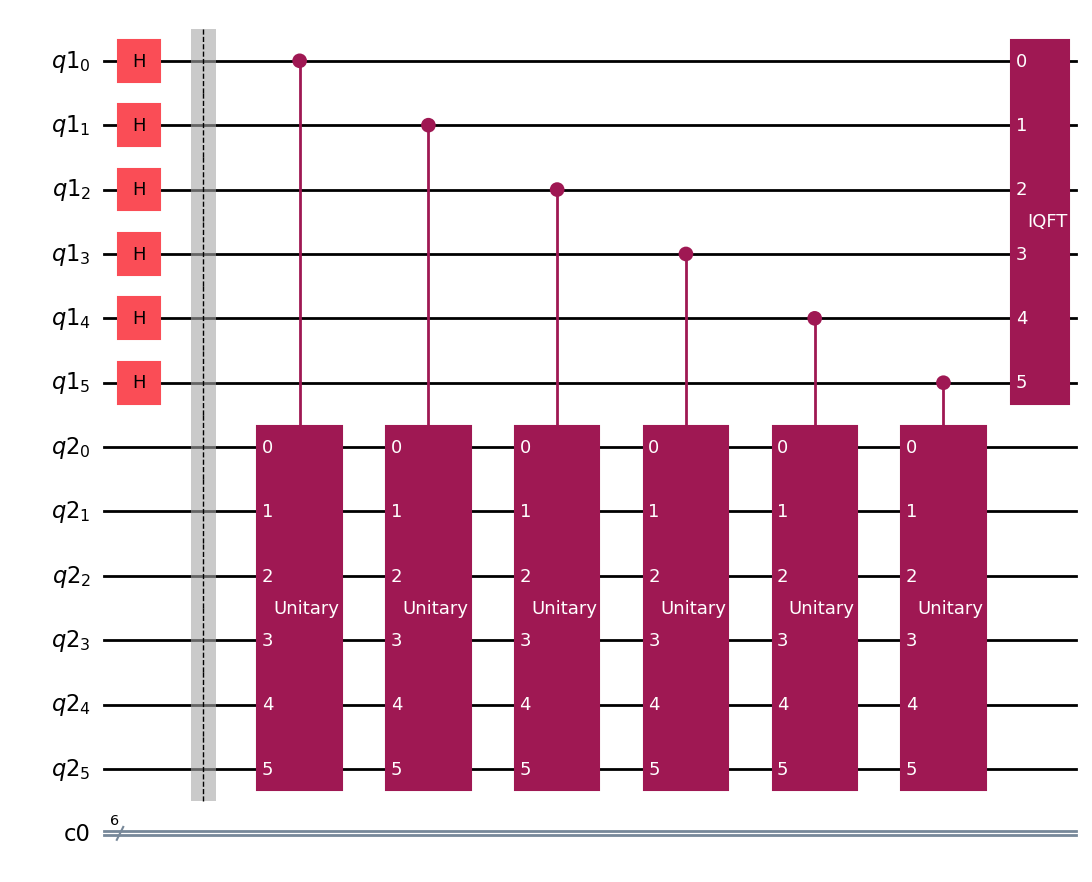

In [4]:
qr_ancilla = QuantumRegister(ancilla_bits)
qr_eigenstate = QuantumRegister(eigen_bits)
cr = ClassicalRegister(ancilla_bits)
qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)

# prepare state
qc.h(qr_ancilla)

qc.barrier()

for i in range(ancilla_bits):
    mat = np.linalg.matrix_power(H, 2**(i))
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[i]] + qr_eigenstate[:] )

# for i in range(int(ancilla_bits/2)):
#     qc.swap(i, ancilla_bits-i-1)

qc.append(QFT(ancilla_bits).inverse(), qr_ancilla)
# measure(qc, ancilla_bits)
qc.draw('mpl')

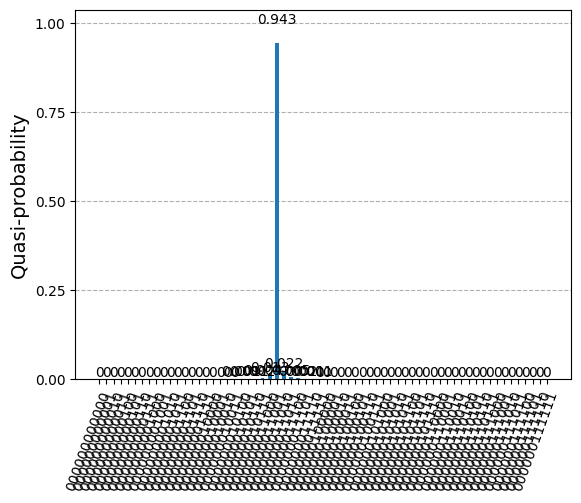

In [5]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()
plot_histogram(ideal_distribution)

In [6]:
max_num = 0
binary_num = ''
for key in ideal_distribution:
    if (ideal_distribution[key] > max_num):
        max_num = ideal_distribution[key]
        binary_num = key
        
binary_num = binary_num[eigen_bits:]

decimal_num = int(binary_num, 2) / (2 ** (ancilla_bits))

print("Lowest energy Eigenvalue", min_eigenvalue.real)
print("Binary Number Output: 0."+str(binary_num))
print("Decimal Number with Equivalent Value:",decimal_num)

Lowest energy Eigenvalue 0.39269908169872414
Binary Number Output: 0.011001
Decimal Number with Equivalent Value: 0.390625
